In [1]:
import logging

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import scipy.stats
from scipy.interpolate import (BSpline, LSQUnivariateSpline, splev, spalde,
                               UnivariateSpline, CubicSpline)
import numpy as np

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 16

In [5]:
# parameters obtained from the different decay-time fits
# from /afs/cern.ch/work/a/adudziak/public/workspace/DsK3fbPAPER/Bs2DsPi_sFit/nominal_resolution/
knots = np.array([0.50, 1.0,  1.5, 2.0, 3.0, 12.0])
MCKdivMCPitimesDataPi = np.array([0.3664407781, 0.566982983334, 0.779405394092,
                                  0.966060333357, 1.0695450788, 1.15319484969])
DataPi = np.array([0.390195, 0.595695, 0.789784,
                   1.014400, 1.099279, 1.188763])
MCPi = np.array([0.475472, 0.678918, 0.934934,
                 1.095435, 1.194616, 1.262790])
MCK = np.array([0.446525, 0.646195, 0.922648,
                1.043234, 1.162303, 1.225006])

In [6]:
# take 1000 evaluation points on the spline-curves
xs = np.linspace(0.4, 14, 1000)

The boundary conditions should be the ones called 'natural' here. At least the [implementation of BoundaryConditions](https://gitlab.cern.ch/lhcb/Urania/blob/d486d8e3643042ae2c5ef05c426ffd9ce7779fa3/PhysFit/B2DXFitters/B2DXFitters/RooCubicSplineKnot.h#L15) and [this comment in the evaluation function of the Spline](https://gitlab.cern.ch/lhcb/Urania/blob/d486d8e3643042ae2c5ef05c426ffd9ce7779fa3/PhysFit/B2DXFitters/src/RooCubicSplineKnot.cxx#L135) suggests this assumption.

In [7]:
# build all neccessary cubic splines
bc_type = 'natural'  # boundary condition: 2nd derivatives = 0
extrapolate = True
spFinal = CubicSpline(knots, MCKdivMCPitimesDataPi, bc_type=bc_type, extrapolate=extrapolate)
ysFinal = spFinal(xs)
spDataPi = CubicSpline(knots, DataPi, bc_type=bc_type, extrapolate=extrapolate)
ysDataPi = spDataPi(xs)
spMCPi = CubicSpline(knots, MCPi, bc_type=bc_type, extrapolate=extrapolate)
ysMCPi = spMCPi(xs)
spMCK = CubicSpline(knots, MCK, bc_type=bc_type, extrapolate=extrapolate)
ysMCK = spMCK(xs)
# compute final acceptance for every evaluation point
spCalculated = lambda x: spDataPi(x) / spMCPi(x) * spMCK(x)
ysCalculated = ysDataPi / ysMCPi * ysMCK

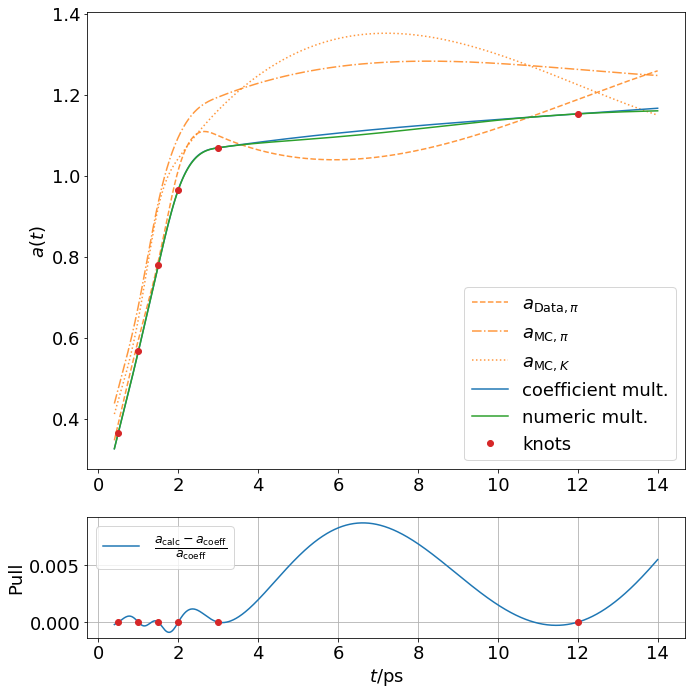

In [8]:
plt.rc('font', size=18)
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
plt.plot(xs, ysDataPi, 'C1--', alpha=0.8, label=r'$a_{\mathrm{Data},\pi}$')
plt.plot(xs, ysMCPi, 'C1-.', alpha=0.8, label=r'$a_{\mathrm{MC},\pi}$')
plt.plot(xs, ysMCK, 'C1:', alpha=0.8, label=r'$a_{\mathrm{MC},K}$')
plt.plot(xs, ysFinal, 'C0', label='coefficient mult.')
plt.plot(xs, ysCalculated, 'C2', label='numeric mult.')
plt.plot(knots, MCKdivMCPitimesDataPi, 'C3o', label='knots')
plt.ylabel(r'$a(t)$')
plt.xlim(0.4, 14)
# plt.ylim(0, 2)
plt.legend(loc='best')

ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)
plt.plot(xs, (ysFinal - ysCalculated) / ysCalculated, label=r'$\frac{a_\mathrm{calc} - a_\mathrm{coeff}}{a_\mathrm{coeff}}$')
plt.plot(knots, np.zeros_like(knots), 'C3o')
plt.legend(loc='best')
plt.grid()
plt.ylabel('Pull')
plt.xlabel(r'$t / \mathrm{ps}$')
plt.tight_layout()
plt.savefig('/Users/kheinicke/spline-plot.pdf')
plt.show()

In [9]:
# have a look at the KS test (is it meaningful at all?)
scipy.stats.ks_2samp(ysFinal, ysCalculated)

Ks_2sampResult(statistic=0.073000000000000009, pvalue=0.0091357424130283308)

In [10]:
# ration of AUCs
ysFinal.sum() / ysCalculated.sum()

1.0032312377635058

# Use a effective smoothing spline to describe the acceptance

In [11]:
fixKnotSpline = LSQUnivariateSpline(xs, ysCalculated, bbox=[0.4, 14], t=knots)
stiffSpline = UnivariateSpline(xs, ysCalculated, bbox=[0.4, 14], s=0.001)

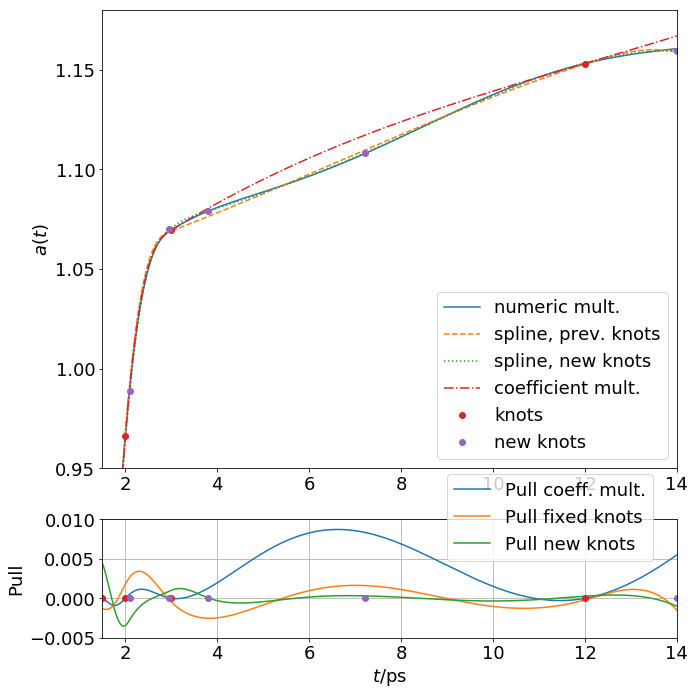

In [12]:
plt.rc('font', size=18)
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
plt.plot(xs, ysCalculated, label='numeric mult.')
plt.plot(xs, fixKnotSpline(xs), '--', label='spline, prev. knots')
plt.plot(xs, stiffSpline(xs), ':', label='spline, new knots')
plt.plot(xs, ysFinal, '-.', label='coefficient mult.')
plt.plot(knots, MCKdivMCPitimesDataPi, 'C3o', label='knots')
plt.plot(stiffSpline.get_knots(), stiffSpline(stiffSpline.get_knots()), 'C4o', label='new knots')
plt.ylabel(r'$a(t)$')
plt.xlim(1.5, 14)
plt.ylim(0.95, 1.18)
plt.legend(loc='best')

ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)
plt.plot(xs, (ysFinal - ysCalculated) / ysCalculated, label=r'Pull coeff. mult.')
plt.plot(xs, (fixKnotSpline(xs) - ysCalculated) / ysCalculated, label=r'Pull fixed knots')
plt.plot(xs, (stiffSpline(xs) - ysCalculated) / ysCalculated, label=r'Pull new knots')
plt.plot(knots, np.zeros_like(knots), 'C3o')
plt.plot(stiffSpline.get_knots(), np.zeros_like(stiffSpline.get_knots()), 'C4o')
plt.legend(loc=(0.6, 0.65))
plt.grid()
plt.ylabel('Pull')
plt.xlabel(r'$t / \mathrm{ps}$')
plt.xlim(1.5, 14)
plt.ylim(-0.005, 0.01)
plt.tight_layout()
plt.savefig('/Users/kheinicke/plot-effective-spline.pdf')
plt.show()